In [ ]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
basedir = "/home/lauro/code/msc-thesis/svgd/"

## Summary

In [ ]:
def get_data(logdir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for rundir in os.listdir(logdir):
        if os.path.isdir(os.path.join(logdir, rundir)):
            configfile, datafile, metricfile = [logdir + rundir + f for f in ["/config.json", "/rundata.json", "/metrics.json"]]
            try:
                with open(configfile, "r") as f:
                    cfgs.append(json.load(f))
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"Failed loading one or more files from {rundir}.")
        else:
            with open(logdir + rundir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
#     for c in cfgs_flat:
#         c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
#         c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
#     configs_df.rename(columns={"optimizer_svgd_args": "lr_svgd", "optimizer_ksd_args": "lr_ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["encoder_layers"] = all_df.encoder_layers.astype('str').astype('category')
    all_df["decoder_layers"] = all_df.decoder_layers.astype('str').astype('category')
    all_df.target_args       = all_df.target_args.astype('str').astype("category")
    all_df["train"] = all_df.train.astype('category')
    
    # to numeric
    all_df.lr_ksd  = pd.to_numeric(all_df.lr_ksd.astype("str"), errors="coerce")
    all_df.lr_svgd = pd.to_numeric(all_df.lr_svgd.astype("str"), errors="coerce")
    
    
    if all_df.isnull().values.any():
        rows_with_nans = all_df.shape[0] - all_df.dropna().shape[0]
        warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")
#         all_df = all_df.dropna()

    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [3]:
ls ../../leonhard-runs/

2-dim/  2-dim-banana/  2-dim-funnel/  2-dim-funnel-70iter/  aug-4/  aug-5/


In [4]:
rundir = basedir + "leonhard-runs/2-dim-funnel/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)

<ipython-input-2-d6a638226f18>:53: UserWarning: Detected NaNs in dataframe. 294 / 567 rows include at least one NaN or inf. Dropping all rows with nonfinite values.
  warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")


In [5]:
relevant = ["se_mean", "se_var", "ksd", "emd"] + ["lr_ksd", 
            "lr_svgd", "svgd_steps", "encoder_layers", "ksd_steps", 
            "train", "lambda_reg", "minimize_ksd_variance", "kernel"]
f_all = frame[relevant]
rundata_all=rundata

## Remove NaNs

In [8]:
nan_idx = onp.asarray(f_all.isnull()["se_mean"])
rundata_all = onp.asarray(rundata_all)
rundata_nan = rundata_all[nan_idx]
rundata_clean = rundata_all[onp.logical_not(nan_idx)]
f_nan = f_all[nan_idx]
f_clean = f_all[onp.logical_not(nan_idx)]

## Just vanilla

In [9]:
v = f_all[f_all.train==False]
rundata_v = rundata_all[f_all.train==False]
del v["lr_ksd"]
del v["encoder_layers"]
del v["lambda_reg"]
del v["minimize_ksd_variance"]

Clear trend for the SVGD learning rate (which is the only difference between the vanilla runs).

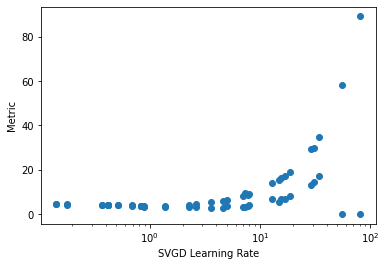

In [69]:
plt.scatter(v.lr_svgd, v.emd)
plt.xlabel("SVGD Learning Rate")
plt.ylabel("Metric")
plt.xscale("log")
# plt.yscale("log")

(1, 120)

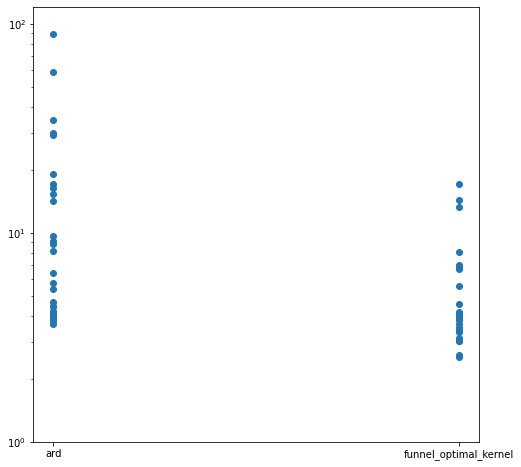

In [70]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(v.kernel, v.emd)
ax.set_yscale("log")
ax.set_ylim((1, 120))

But maybe emd is not so good at measuring the small differences in the narror neck of the funnel.

## Rundata

Get best performances from each

#### Just vanilla

Text(0.5, 1.0, 'Best performing unencoded run')

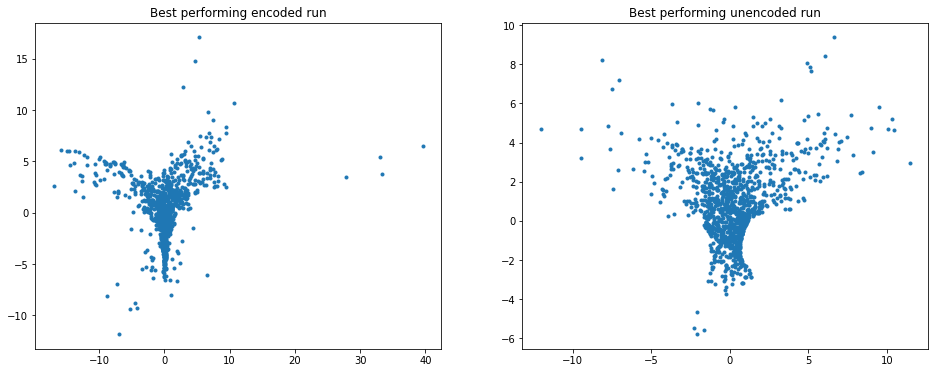

In [17]:
fig, axs = plt.subplots(1, 2, figsize=[16, 6])

ax = axs[0]
ind = f_all[(f_all.emd>0) & (f_all.train==False)].emd.idxmin()
p = onp.array(rundata_all[ind]["particles"])
ax.scatter(p[:,0], p[:,1], marker=".")
ax.set_title("Best performing encoded run")

ax = axs[1]
ind = f_all[(f_all.kernel=="ard") & (f_all.emd > 0) & (f_all.train==False)].emd.idxmin()
p = onp.array(rundata_all[ind]["particles"])
ax.scatter(p[:,0], p[:,1], marker=".")
ax.set_title("Best performing unencoded run")

### let's get some more plots

In [36]:
f_good = v[(v.emd<4) & (v.emd>0)]
rundata_good = rundata_v[(v.emd<4) & (v.emd>0)]

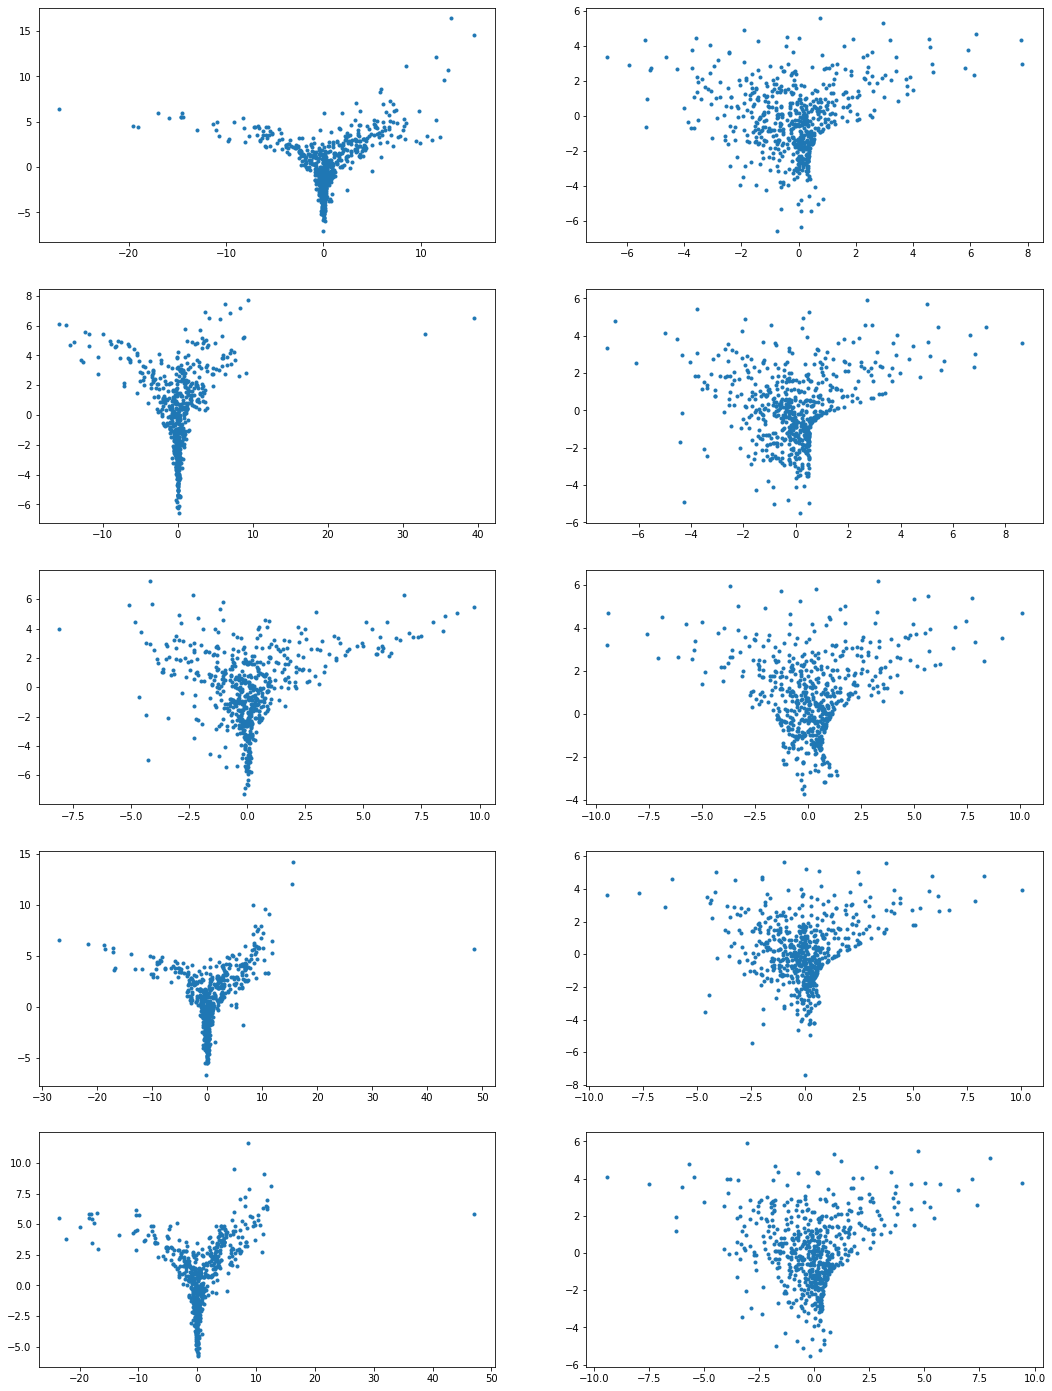

In [42]:
fig, axs = plt.subplots(5, 2, figsize=[18, 25])
for ax, dat in zip(axs[:, 0], rundata_good[f_good.kernel=="funnel_optimal_kernel"]):
    p = onp.array(dat["particles"])[dat["leader_idx"]]
    ax.scatter(p[:,0], p[:,1], marker=".")

for ax, dat in zip(axs[:, 1], rundata_good[f_good.kernel=="ard"]):
    p = onp.array(dat["particles"])[dat["leader_idx"]]
    ax.scatter(p[:,0], p[:,1], marker=".")

# Vanilla + MLP

## SVGD LR
Again, a clear trend for SVGD learning rate. Not so clear for the layer sizes. Interestingly, Vanilla does (relatively) better here.

(1, 120)

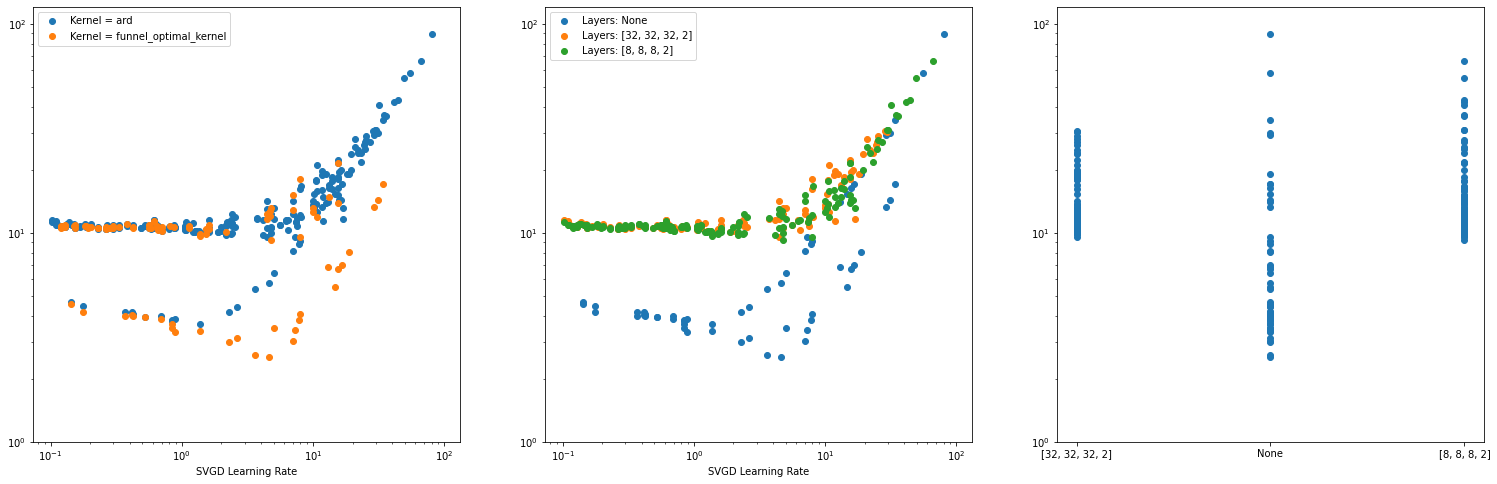

In [52]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
for ax, grouplabel, prefix in zip(axs, ("kernel", "encoder_layers"), ("Kernel = ", "Layers: ")):
    groups = f_all.groupby(grouplabel)
    for name, group in groups:
        ax.scatter(group.lr_svgd, group.emd, marker="o", label=prefix + str(name))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim((1, 120)) # for emd
    ax.legend()
    _ = ax.set_xlabel("SVGD Learning Rate")

axs[2].scatter(f_all.encoder_layers, f_all.emd)
axs[2].set_yscale("log")
axs[2].set_ylim((1, 120))

# Just MLP

In [53]:
t = f_all[f_all.train]

## Lambda
The Autoencoder regularization parameter is important:

Unfortunately, I didn't sample small enough (will fix in next run).

(1.9646416707165855e-05, 3448.2817483325093)

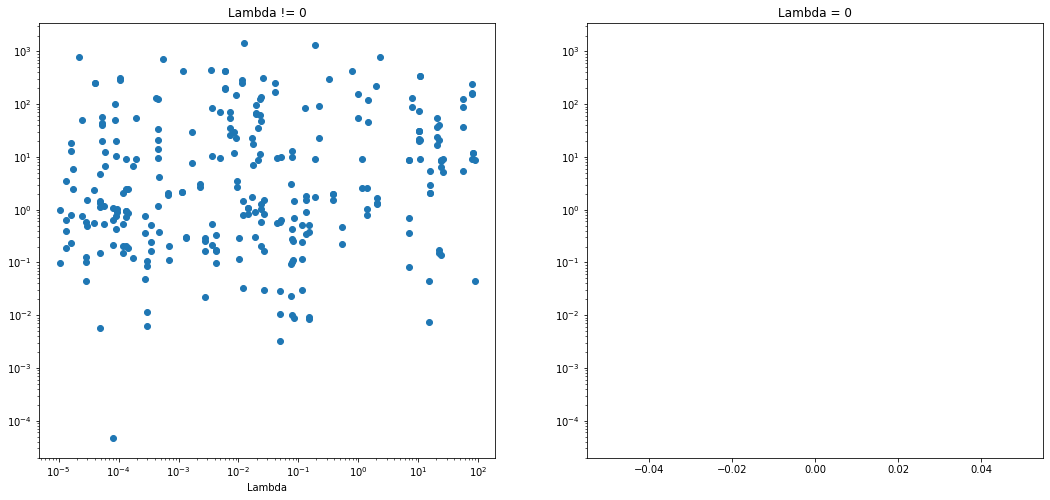

In [57]:
fig, axs = plt.subplots(1, 2, figsize=[18,8])
ax = axs[0]
ax.set_title("Lambda != 0")
ax.scatter(t.lambda_reg, t.se_mean)
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0.001, 120)
# ax.set_ylim(0.004, 100)
ax.set_xlabel("Lambda")

ax = axs[1]
ax.set_title("Lambda = 0")
ax.scatter(t[t.lambda_reg==0].lambda_reg, t[t.lambda_reg==0].se_mean)
ax.set_yscale("log")
ax.set_ylim(axs[0].get_ylim())

For next plots, leave out shitty unregularized results.

In [16]:
f = f[f.lambda_reg != 0]

## KSD Variance

This parameter is irrelevant

(0.1, 100)

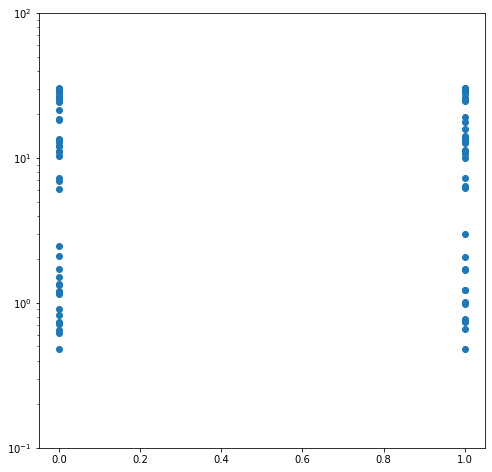

In [20]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(f.minimize_ksd_variance, f.se_mean)
ax.set_yscale("log")
ax.set_ylim(0.1, 100)

## Encoder / decoder LR

This learning rate is also important. Tho need more data here too.

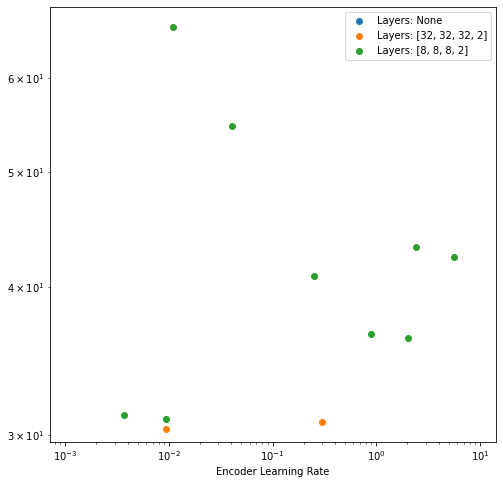

In [68]:
fig, ax = plt.subplots(figsize=[8,8])
groups = t.groupby(grouplabel)
for name, group in groups:
    ax.scatter(group.lr_ksd, group.emd, marker="o", label=prefix + str(name))
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
_ = ax.set_xlabel("Encoder Learning Rate")

# Rundata

In [22]:
ind = 2
f.iloc[ind]

se_mean                                                           0.770781
se_var                                                             6.61634
ksd                                                              0.0219937
emd                                                                2.06606
lr_ksd                                                            0.191165
lr_svgd                                                            1.59546
svgd_steps                                                               1
encoder_layers                                                   [4, 4, 1]
ksd_steps                                                               10
train                                                                 True
lambda_reg                                                        0.288901
target_args              [[[-1.0, 1.0], [-2.0, 3.0314331330207964], [-1...
minimize_ksd_variance                                                 True
Name: 2, dtype: object

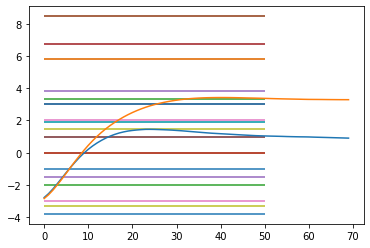

In [23]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mean = onp.array(rundata[ind]["training_mean"])
tru_mean = configs[ind]["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 50, colors=colorcycle)

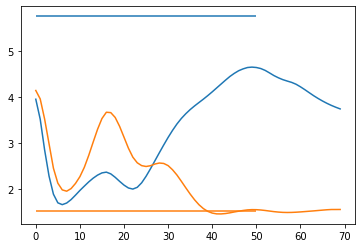

In [31]:
var = onp.array(rundata[ind]["training_var"])
tru_var = onp.diag(configs[ind]["svgd"]["target_args"][1])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 50, colors=colorcycle)